In [1]:
%matplotlib inline
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
from plots import *
from kls import *
from nats import *
from utils import *
from objectives import *
from torch.distributions.normal import Normal
from torch.distributions.one_hot_categorical import OneHotCategorical as cat
from torch.distributions.gamma import Gamma
import sys
import time
import datetime
sys.path.append('/home/hao/Research/probtorch/')
import probtorch
from probtorch.util import expand_inputs
print('probtorch:', probtorch.__version__, 
      'torch:', torch.__version__, 
      'cuda:', torch.cuda.is_available())

probtorch: 0.0+5a2c637 torch: 1.0.0 cuda: True


In [2]:
N = 30
K = 3
D = 2

## Model Parameters
NUM_SAMPLES = 10
NUM_HIDDEN1 = 8
NUM_STATS = 1 + 2 * D
NUM_LATENTS =  D
## Training Parameters
SAMPLE_DIM = 0
BATCH_DIM = 1
BATCH_SIZE = 20
NUM_EPOCHS = 10000
LEARNING_RATE = 1e-4
CUDA = torch.cuda.is_available()
PATH = 'gibbs-NG'

In [3]:
Xs = torch.from_numpy(np.load('gmm_dataset_conjugate/obs.npy')).float()
STATES = torch.from_numpy(np.load('gmm_dataset_conjugate/states.npy')).float()
Pi = torch.from_numpy(np.load('gmm_dataset_conjugate/init.npy')).float()
NUM_SEQS = Xs.shape[0]
NUM_BATCHES = int((Xs.shape[0] / BATCH_SIZE))

In [4]:
class Enc_eta(nn.Module):
    def __init__(self, num_obs=D,
                       num_hidden1=NUM_HIDDEN1,
                       num_stats=NUM_STATS,
                       num_latents=NUM_LATENTS):
        super(self.__class__, self).__init__()

        self.mus_mu = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        self.mus_log_nu = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        
        self.tau_log_alpha = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        
        self.tau_log_beta = nn.Sequential(
            nn.Linear(num_stats, num_hidden1),
            nn.Tanh(),
            nn.Linear(num_hidden1, int(0.5*num_hidden1)),
            nn.Tanh(),
            nn.Linear(int(0.5*num_hidden1), num_latents))
        
        self.prior_mu = torch.zeros((K, D))
        self.prior_nu = torch.ones((K, D)) * 0.3
        self.prior_alpha = torch.ones((K, D)) * 3
        self.prior_beta = torch.ones((K, D)) * 3
        if CUDA:
            self.prior_mu = self.prior_mu.cuda()
            self.prior_nu = self.prior_nu.cuda()
            self.prior_alpha = self.prior_alpha.cuda()
            self.prior_beta = self.prior_beta.cuda()
        
    def forward(self, stat1, stat2, stat3):
        q = probtorch.Trace()
        stats_c1 = torch.cat((stat1[:, :, 0].unsqueeze(-1), stat2[:, :, 0, :], stat3[:, :, 0, :]), -1) ## S * B * 1+2*D
        stats_c2 = torch.cat((stat1[:, :, 1].unsqueeze(-1), stat2[:, :, 1, :], stat3[:, :, 1, :]), -1) ## S * B * 1+2*D
        stats_c3 = torch.cat((stat1[:, :, 2].unsqueeze(-1), stat2[:, :, 2, :], stat3[:, :, 2, :]), -1) ## S * B * 1+2*D
        ##
        q_alpha1 = self.tau_log_alpha(stats_c1).exp()
        q_beta1 = self.tau_log_beta(stats_c1).exp()
        q_alpha2 = self.tau_log_alpha(stats_c2).exp()
        q_beta2 = self.tau_log_beta(stats_c2).exp()
        q_alpha3 = self.tau_log_alpha(stats_c3).exp()
        q_beta3 = self.tau_log_beta(stats_c3).exp()
        ##
        q_alpha = torch.cat((q_alpha1.unsqueeze(-2), q_alpha2.unsqueeze(-2), q_alpha3.unsqueeze(-2)), -2)
        q_beta = torch.cat((q_beta1.unsqueeze(-2), q_beta2.unsqueeze(-2), q_beta3.unsqueeze(-2)), -2)
        precisions = Gamma(q_alpha, q_beta).sample()
        q.gamma(q_alpha,
                q_beta,
                value=precisions,
                name='precisions')
        
        p = probtorch.Trace()
        p.gamma(self.prior_alpha,
                self.prior_beta,
                value=q['precisions'],
                name='precisions')   
        ##
        q_mu1 = self.mus_mu(stats_c1)
        q_nu1 = self.mus_log_nu(stats_c1).exp()
        q_mu2 = self.mus_mu(stats_c2)
        q_nu2 = self.mus_log_nu(stats_c2).exp()  
        q_mu3 = self.mus_mu(stats_c3)
        q_nu3 = self.mus_log_nu(stats_c3).exp()     
        
        q_mu = torch.cat((q_mu1.unsqueeze(-2), q_mu2.unsqueeze(-2), q_mu3.unsqueeze(-2)), -2)
        q_nu = torch.cat((q_nu1.unsqueeze(-2), q_nu2.unsqueeze(-2), q_nu3.unsqueeze(-2)), -2)
        ##
        means = Normal(q_mu, 1. / (q_nu * q['precisions'].value).sqrt()).sample()
        q.normal(q_mu, 
                 1. / (q_nu * q['precisions'].value).sqrt(), 
                 value=means, 
                 name='means')
        p.normal(self.prior_mu, 
                 1. / (self.prior_nu * q['precisions'].value).sqrt(), 
                 value=q['means'], 
                 name='means')    
        return q, p, q_nu
        
def initialize():
    enc_eta = Enc_eta()
    if CUDA:
        enc_eta.cuda()
    optimizer =  torch.optim.Adam(list(enc_eta.parameters()),lr=LEARNING_RATE, betas=(0.9, 0.99))    
    return enc_eta, optimizer

In [5]:
def Eubo_idw(q, p, obs, states, K, D):
    ## for individual importance weight, S * B * K
    log_q_mu = q['means'].log_prob.sum(-1)
    log_q_tau = q['precisions'].log_prob.sum(-1)
    log_p_mu = p['means'].log_prob.sum(-1)
    log_p_tau = p['precisions'].log_prob.sum(-1)

    obs_mu = q['means'].value.view(NUM_SAMPLES, BATCH_SIZE, K, D)
    obs_sigma = 1. / (q['precisions'].value.view(NUM_SAMPLES, BATCH_SIZE, K, D)).sqrt()
    ##
    labels = states.argmax(-1)
    labels_flat = labels.unsqueeze(-1).repeat(1, 1, 1, D)
    obs_mu_expand = torch.gather(obs_mu, 2, labels_flat)
    obs_sigma_expand = torch.gather(obs_sigma, 2, labels_flat)
    log_obs = Normal(obs_mu_expand, obs_sigma_expand).log_prob(obs).sum(-1) ## S * B * N, need to group
    log_obs = torch.cat([((labels==k).float() * log_obs).sum(-1).unsqueeze(-1) for k in range(K)], -1)
    log_weights = log_obs + log_p_mu + log_p_tau - log_q_mu - log_q_tau
    weights = F.softmax(log_weights, 0).detach()
    eubo = (weights * log_weights).sum(0).sum(-1).mean()
    elbo = log_weights.sum(-1).mean()
    ess = (1. / (weights**2).sum(0)).mean(-1).mean()
    return eubo, elbo, ess, weights

In [6]:
enc_eta, optimizer = initialize()

In [7]:
EUBOs = []
ELBOs = []
ESSs = []
KLs_ex = []
KLs_in = []


flog = open('results/log-' + PATH + '.txt', 'w+')
flog.write('EUBO\tELBO\tESS\tIWKLs_ex\tIWKLs_in\tAKLs_ex\tAKLs_in\n')
flog.close()
time_start = time.time()
for epoch in range(NUM_EPOCHS):
    indices = torch.randperm(NUM_SEQS)
    EUBO = 0.0
    ELBO = 0.0
    ESS = 0.0
    IWKL_ex = 0.0
    IWKL_in = 0.0
    AKL_ex = 0.0
    AKL_in = 0.0
    for step in range(NUM_BATCHES):
        optimizer.zero_grad()
        batch_indices = indices[step*BATCH_SIZE : (step+1)*BATCH_SIZE]
        obs = Xs[batch_indices]
        states = STATES[batch_indices]
        data = shuffler(torch.cat((obs, states), -1)).repeat(NUM_SAMPLES, 1, 1, 1)
        if CUDA:
            obs =data.cuda()[:, :, :, :2]
            states = data.cuda()[:, :, :, 2:]

        stat1, stat2, stat3 = data_to_stats(obs, states, K, D)
        q, p, q_nu = enc_eta(stat1, stat2, stat3)
        eubo, elbo, ess, weights = Eubo_idw(q, p, obs, states, K, D)
        ## KLs for mu given true sigma
        post_mu, post_nu, post_alpha, post_beta = Post_mu_tau(stat1, stat2, stat3, enc_eta.prior_mu, enc_eta.prior_nu, enc_eta.prior_alpha, enc_eta.prior_beta, D)
        q_mu = q['means'].dist.loc
        q_alpha = q['precisions'].dist.concentration
        q_beta = q['precisions'].dist.rate
        kl_ex, kl_in = kls_NGs(q_mu, q_nu, q_alpha, q_beta, post_mu, post_nu, post_alpha, post_beta)
        iwkl_ex = (weights * kl_ex).sum(0).sum(-1).mean()
        iwkl_in = (weights * kl_in).sum(0).sum(-1).mean()
        akl_ex = kl_ex.sum(-1).mean()
        akl_in = kl_in.sum(-1).mean()
        ## gradient step
        eubo.backward()
        optimizer.step()
        EUBO += eubo.item()
        ELBO += elbo.item()
        ESS += ess.item()
        IWKL_ex += iwkl_ex.item()
        IWKL_in += iwkl_in.item()
        AKL_ex += akl_ex.item()
        AKL_in += akl_in.item()
    EUBOs.append(EUBO / NUM_BATCHES)
    ELBOs.append(ELBO / NUM_BATCHES)
    ESSs.append(ESS / NUM_BATCHES) 
    flog = open('results/log-' + PATH + '.txt', 'a+')
    print('%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f\t%.3f'
            % (EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, AKL_ex/NUM_BATCHES, AKL_in/NUM_BATCHES,
               IWKL_ex/NUM_BATCHES, IWKL_in/NUM_BATCHES), file=flog)
    flog.close()
    if epoch % 10 ==0:
        time_end = time.time()
        print('epoch=%d, EUBO=%.3f, ELBO=%.3f, ESS=%.3f, IWKL_ex=%.3f, IWKL_in=%.3f (%ds)'
            % (epoch, EUBO/NUM_BATCHES, ELBO/NUM_BATCHES, ESS/NUM_BATCHES, 
               IWKL_ex/NUM_BATCHES, IWKL_in/NUM_BATCHES, time_end - time_start))
        time_start = time.time()

epoch=0, EUBO=-308.577, ELBO=-856.364, ESS=1.092, IWKL_ex=657.474, IWKL_in=23.670 (6s)
epoch=10, EUBO=-236.303, ELBO=-395.618, ESS=1.234, IWKL_ex=197.484, IWKL_in=21.757 (68s)
epoch=20, EUBO=-224.560, ELBO=-326.793, ESS=1.405, IWKL_ex=128.043, IWKL_in=20.651 (65s)
epoch=30, EUBO=-219.155, ELBO=-301.831, ESS=1.528, IWKL_ex=103.684, IWKL_in=19.389 (60s)
epoch=40, EUBO=-215.297, ELBO=-293.051, ESS=1.623, IWKL_ex=94.906, IWKL_in=18.099 (61s)
epoch=50, EUBO=-213.012, ELBO=-290.006, ESS=1.667, IWKL_ex=91.041, IWKL_in=17.399 (57s)
epoch=60, EUBO=-211.675, ELBO=-287.309, ESS=1.740, IWKL_ex=88.718, IWKL_in=16.877 (69s)
epoch=70, EUBO=-210.557, ELBO=-284.543, ESS=1.807, IWKL_ex=85.942, IWKL_in=16.002 (69s)
epoch=80, EUBO=-209.795, ELBO=-279.768, ESS=1.884, IWKL_ex=81.580, IWKL_in=15.206 (69s)
epoch=90, EUBO=-208.674, ELBO=-276.423, ESS=1.936, IWKL_ex=77.610, IWKL_in=14.511 (68s)
epoch=100, EUBO=-207.772, ELBO=-273.307, ESS=1.954, IWKL_ex=74.568, IWKL_in=14.020 (66s)
epoch=110, EUBO=-207.385, ELB

KeyboardInterrupt: 

In [8]:
torch.save(enc_eta.state_dict(), 'weights/enc-%s' + PATH)

In [9]:
def plot_results(EUBOs, ELBOs, ESSs, num_samples, num_epochs, lr):
    fig = plt.figure(figsize=(15, 15))
    fig.tight_layout()
    ax1 = fig.add_subplot(3, 1, 1)
    ax2 = fig.add_subplot(3, 1, 2)
    ax3 = fig.add_subplot(3, 1, 3)
    ax1.plot(EUBOs, 'r', label='EUBOs')
    ax1.plot(ELBOs, 'b', label='ELBOs')

    ax1.tick_params(labelsize=18)
    
    ax3.plot(np.array(ESSs) / num_samples, 'm', label='ESS')
    ax1.set_title('epoch=%d, batch_size=%d, lr=%.1E, samples=%d' % (num_epochs, BATCH_SIZE, lr, num_samples), fontsize=18)
    ax1.set_ylim([-240, -100])
    ax1.legend()
    ax3.legend()
    ax3.tick_params(labelsize=18)
    ax3.set_ylim([0,1])
    plt.savefig('train_' + PATH + '.svg')

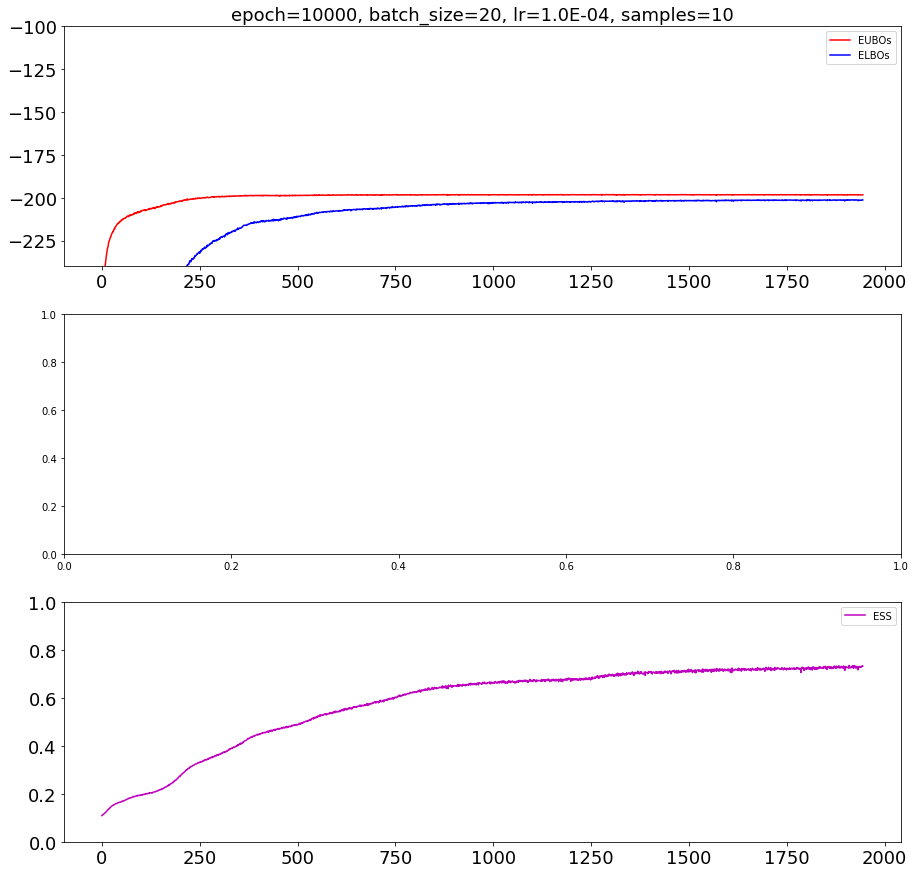

In [10]:
plot_results(EUBOs, ELBOs, ESSs, NUM_SAMPLES, NUM_EPOCHS, LEARNING_RATE)

In [11]:
def sample_single_batch(num_seqs, N, K, D, batch_size):
    indices = torch.randperm(num_seqs)
    batch_indices = indices[0*batch_size : (0+1)*batch_size]
    obs = Xs[batch_indices]
    states = STATES[batch_indices]
    data = shuffler(torch.cat((obs, states), -1)).repeat(NUM_SAMPLES, 1, 1, 1)
    if CUDA:
        obs =data.cuda()[:, :, :, :2]
        states = data.cuda()[:, :, :, 2:]
    return obs, states

obs, states = sample_single_batch(NUM_SEQS, N, K, D, batch_size=25)
stat1, stat2, stat3 = data_to_stats(obs, states, N, K, D)
q, p, _ = enc_eta(stat1, stat2, stat3)

In [12]:
def plot_samples(obs, states, q, batch_size):
    colors = ['r', 'b', 'gold']
    fig = plt.figure(figsize=(25,25))
    xs = obs[0].cpu()
    zs = states[0].cpu()
    mu_means = q['means'].dist.loc[0].cpu().data.numpy()
    tau_means = (q['precisions'].dist.concentration[0] / q['precisions'].dist.rate[0]).cpu().data.numpy()
    for b in range(batch_size):
        ax = fig.add_subplot(int(batch_size / 5), 5, b+1)
        x = xs[b].data.numpy()
        z = zs[b].data.numpy()
        mu = mu_means[b].reshape(K, D)
        sigma2 = 1. / tau_means[b]
        assignments = z.argmax(-1)
        for k in range(K):
            cov_k = np.diag(sigma2[k])
            xk = x[np.where(assignments == k)]
            ax.scatter(xk[:, 0], xk[:, 1], c=colors[k])
            plot_cov_ellipse(cov=cov_k, pos=mu[k], nstd=2, ax=ax, alpha=0.2, color=colors[k])
        ax.set_ylim([-15, 15])
        ax.set_xlim([-15, 15])
    plt.savefig('results/modes-' + PATH + '.svg')

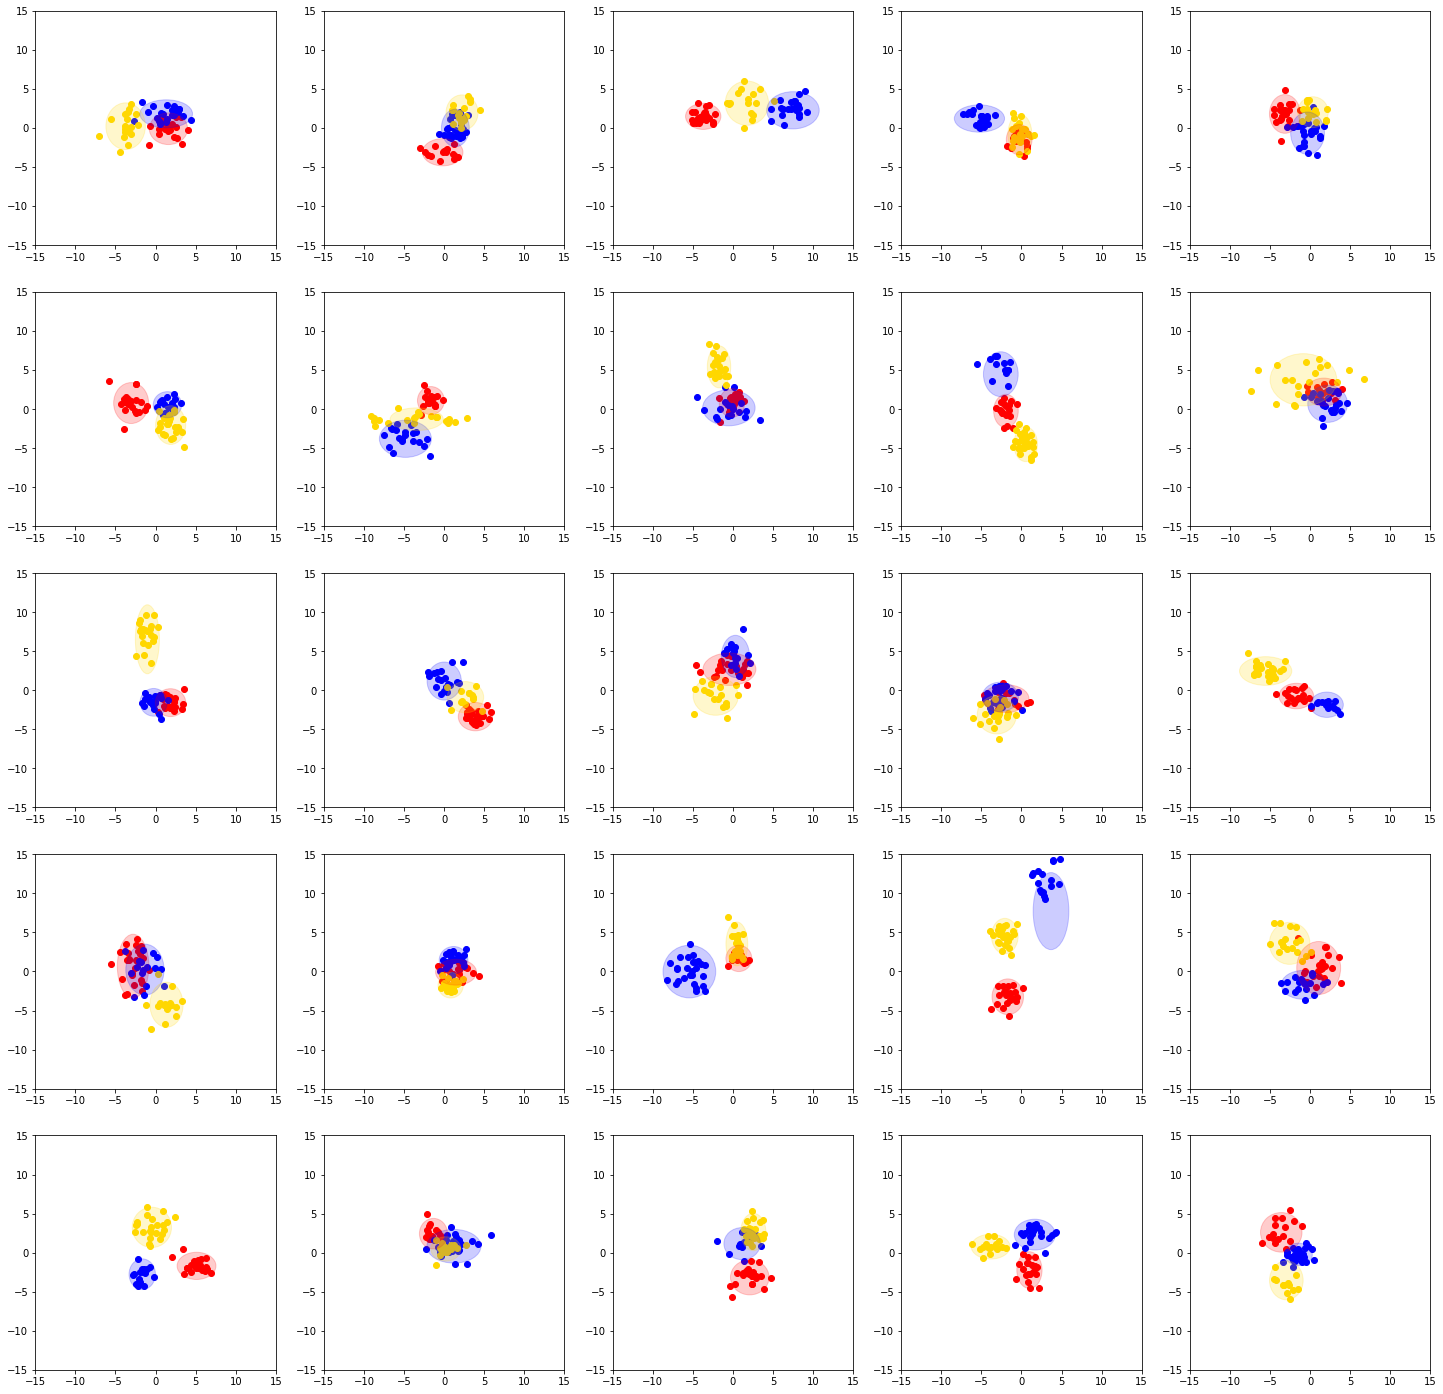

In [13]:
plot_samples(obs, states, q, batch_size=25)